# **SMS Spam Classifier using NLP and Machine Learning**

## **1. Import Libraries**

In [1]:
#=================================================================
# For data manipulation, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
import calendar
from datetime import datetime
import datetime
import pickle 
#=================================================================
# From sklearn import required classes
#=================================================================
from sklearn import metrics
from sklearn.metrics import accuracy_score , confusion_matrix, precision_score , classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz 
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Image
from graphviz import Source
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
#=================================================================
# for Text processing
#=================================================================
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from wordcloud import WordCloud
from collections import Counter

## **2. Load the Dataset and perform Data cleaning**

In [2]:
df = pd.read_csv("spam_sms_dataset.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.shape

(5572, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.rename(columns={'v1':'Target', 'v2':'Text'}, inplace=True)
df.head(3)

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
df = df[['Text', 'Target']]
df.head(3)

,Text,Target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam


In [7]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])
df.head()

,Text,Target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
# check for missing values
df.isnull().sum()

Text      0
Target    0
dtype: int64

In [9]:
# check for duplicates
df.duplicated().sum()

403

In [10]:
# remove duplicates 
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [11]:
df.shape

(5169, 2)

## **3. Exploratory Data Analysis (EDA)**

In [12]:
df.head()

,Text,Target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### **3.1. Percentage of Target label**

In [13]:
df['Target'].value_counts()

0    4516
1     653
Name: Target, dtype: int64

**observation : It is an imbalanced dataset**

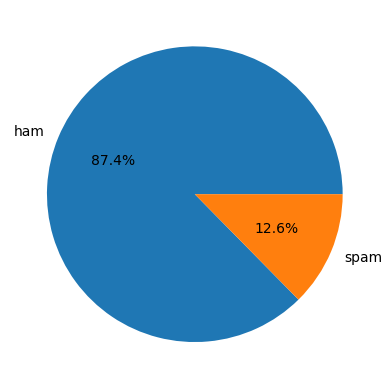

In [14]:
plt.pie(df['Target'].value_counts(), labels = ['ham', 'spam'], autopct='%0.1f%%')
plt.show()

### **3.2. Analysis of number of Characters, Words and Sentences in messages**

In [15]:
# get number of characters in each row of text column 
df["num_characters"] = df['Text'].apply(len)   
df.head()

,Text,Target,num_characters
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


In [16]:
# number of words in each row of text column
df['num_words'] = df['Text'].apply(lambda x : len(nltk.word_tokenize(x)))
df.head()

,Text,Target,num_characters,num_words
0,"Go until jurong point, crazy.. Available only ...",0,111,24
1,Ok lar... Joking wif u oni...,0,29,8
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37
3,U dun say so early hor... U c already then say...,0,49,13
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15


In [17]:
#number of sentences in each row of text column 
df['num_sentences'] = df['Text'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head()

,Text,Target,num_characters,num_words,num_sentences
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,Ok lar... Joking wif u oni...,0,29,8,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
3,U dun say so early hor... U c already then say...,0,49,13,1
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1


In [18]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
df.shape

(5169, 5)

In [20]:
# get all ham messages 
df_ham = df[df['Target']== 0]
df_ham.head(3)

,Text,Target,num_characters,num_words,num_sentences
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,Ok lar... Joking wif u oni...,0,29,8,2
3,U dun say so early hor... U c already then say...,0,49,13,1


In [21]:
# get all spam messages 
df_spam = df[df['Target']==1]
df_spam.head(3)

,Text,Target,num_characters,num_words,num_sentences
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
5,FreeMsg Hey there darling it's been 3 week's n...,1,148,39,4
8,WINNER!! As a valued network customer you have...,1,158,32,5


In [22]:
# Descriptive statistics of ham messages
df_ham.describe()

,Target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [23]:
# Descriptive statistics of spam messages
df_spam.describe()

,Target,num_characters,num_words,num_sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


**Distribution of characters, words and sentences in ham and spam messages**

<AxesSubplot: xlabel='num_characters', ylabel='Count'>

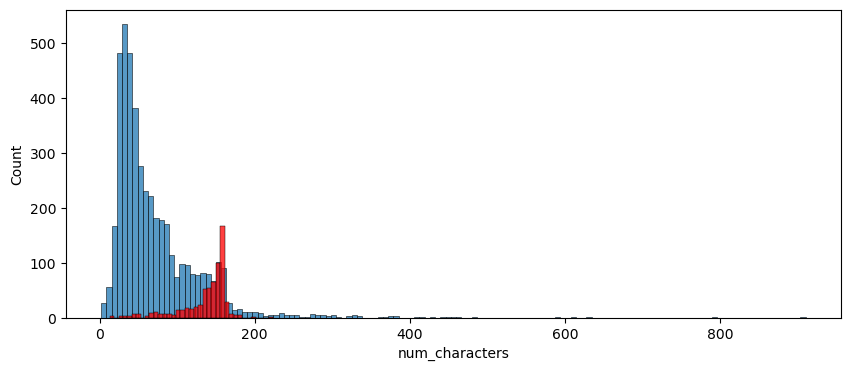

In [24]:
plt.figure(figsize=(10,4))
sns.histplot(df_ham['num_characters'])
sns.histplot(df_spam['num_characters'], color='red')

**Observation : mean number of characters in spam messages is greater than ham messages**

<AxesSubplot: xlabel='num_words', ylabel='Count'>

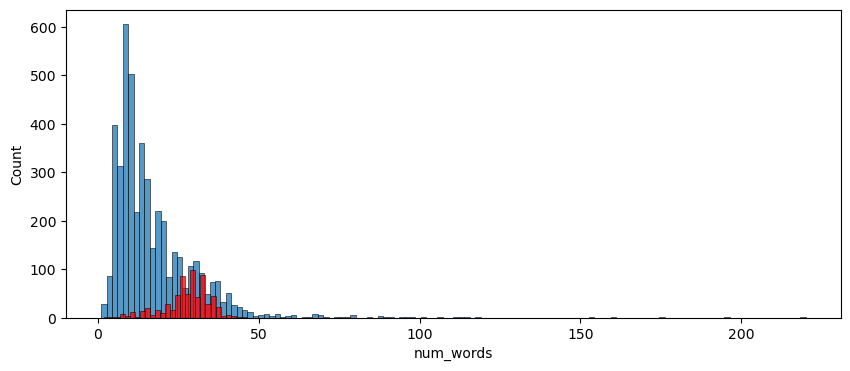

In [25]:
plt.figure(figsize=(10,4))
sns.histplot(df_ham['num_words'])
sns.histplot(df_spam['num_words'], color='red')

**Observation : mean number of words in spam messages is greater than ham messages**

### **3.3. Pair plot**

<Figure size 1200x600 with 0 Axes>

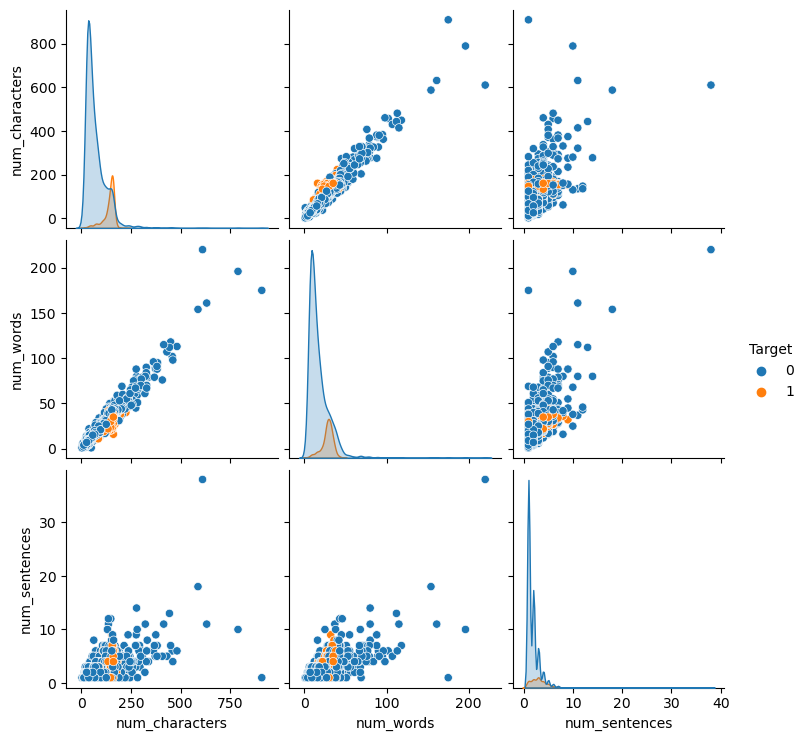

In [26]:
plt.figure(figsize=(12,6))
sns.pairplot(df,hue='Target')

### **3.4. Heat map**

<AxesSubplot: >

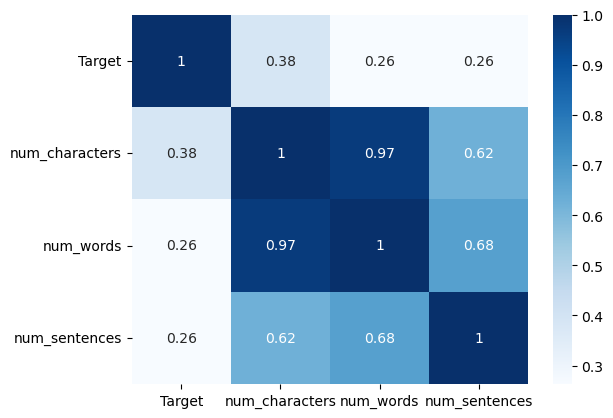

In [27]:
sns.heatmap(df[['Target', 'num_characters', 'num_words', 'num_sentences']].corr(),annot=True, cmap='Blues')

**Observations:**

**'num_characters' feature is having high correlation with 'Target' label compared to other features, moreover 'num_words' and 'num_sentences' are having high correlation with 'num_characters', hence only 'num_characters' feature can be used for further analysis.**

## **4. Text Preprocessing**

**Perform below mentioned operations on the text**

    1. Lower case conversion
    2. Tokenization
    3. Removing special characters
    4. Removing stop words and punctuation
    5. Stemming

### **4.1. Function to perform Text processing**

In [28]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()               # 1. lower case conversion
    text = nltk.word_tokenize(text)   # 2. Tokenization

    y = []
    for i in text:
        if i.isalnum():               # 3. Removing special characters
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:                    # 4. Removing stop words and punctuation
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:                   # 5. Stemming
        y.append(ps.stem(i))  

    return " ".join(y)


In [29]:
df['Transformed_text'] = df['Text'].apply(transform_text)

In [30]:
df.head()

,Text,Target,num_characters,num_words,num_sentences,Transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goe usf live around though


### **4.2. Word Cloud**

**word cloud plots are used to understand the most frequently occuring words in both spam and ham messages**

In [31]:
wc = WordCloud(width=700,height=400,min_font_size=10,background_color='white')

In [32]:
# spam messages
spam_wc = wc.generate(df[df['Target'] == 1]['Transformed_text'].str.cat(sep=" "))

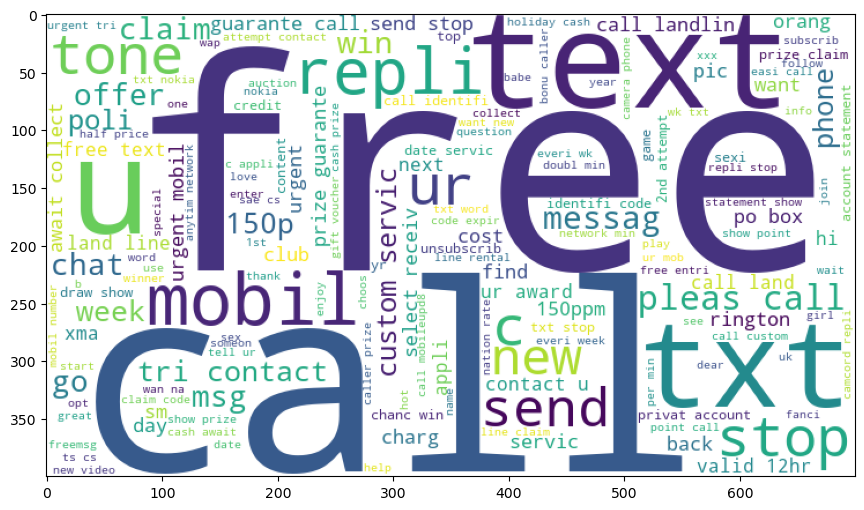

In [33]:
plt.figure(figsize=(12,6))
plt.imshow(spam_wc)

In [34]:
# ham messages
ham_wc = wc.generate(df[df['Target'] == 0]['Transformed_text'].str.cat(sep=" "))

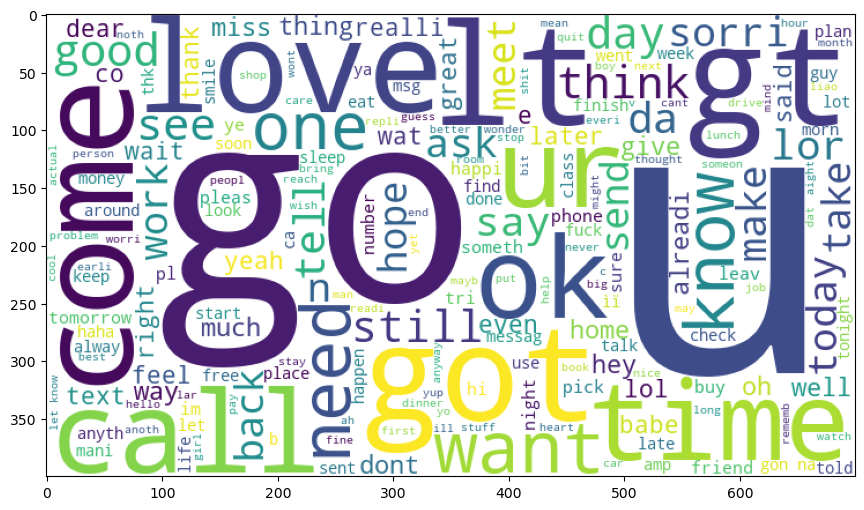

In [35]:
plt.figure(figsize=(12,6))
plt.imshow(ham_wc)

### **4.3. Find the top frequent words**

In [36]:
df.head()

,Text,Target,num_characters,num_words,num_sentences,Transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goe usf live around though


#### **4.3.1. Spam messages**

In [37]:
df_spam = df[df['Target']==1]
df_spam.head()

,Text,Target,num_characters,num_words,num_sentences,Transformed_text
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
5,FreeMsg Hey there darling it's been 3 week's n...,1,148,39,4,freemsg hey darl 3 week word back like fun sti...
8,WINNER!! As a valued network customer you have...,1,158,32,5,winner valu network custom select receivea pri...
9,Had your mobile 11 months or more? U R entitle...,1,154,31,3,mobil 11 month u r entitl updat latest colour ...
11,"SIX chances to win CASH! From 100 to 20,000 po...",1,136,31,3,six chanc win cash 100 pound txt csh11 send co...


In [38]:
spam_text = df_spam['Transformed_text'].tolist()
spam_text[:5]

['free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18',
 'freemsg hey darl 3 week word back like fun still tb ok xxx std chg send rcv',
 'winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour',
 'mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030',
 'six chanc win cash 100 pound txt csh11 send cost 6day tsandc appli repli hl 4 info']

In [39]:
# create corpus 
spam_corpus = []
for sentence in spam_text:
    for word in sentence.split():
        spam_corpus.append(word)

In [40]:
spam_corpus[:10]

['free', 'entri', '2', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt']

In [41]:
df_spam_count = pd.DataFrame(Counter(spam_corpus).most_common(30))
df_spam_count.rename(columns={0: 'word', 1: 'count'}, inplace=True)
df_spam_count.head()

,word,count
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122


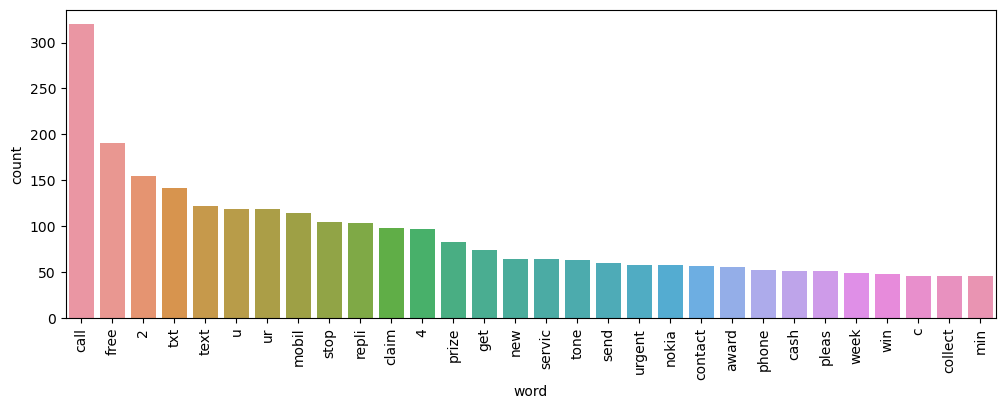

In [42]:
plt.figure(figsize=(12,4))
sns.barplot(data=df_spam_count, x = 'word', y='count')
plt.xticks(rotation='vertical')
plt.show()

#### **4.3.2. ham messages**

In [43]:
df_ham = df[df['Target']==0]
df_ham.head()

,Text,Target,num_characters,num_words,num_sentences,Transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goe usf live around though
6,Even my brother is not like to speak with me. ...,0,77,18,2,even brother like speak treat like aid patent


In [44]:
ham_text = df_ham['Transformed_text'].tolist()
ham_text[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'even brother like speak treat like aid patent']

In [45]:
# create corpus 
ham_corpus = []
for sentence in ham_text:
    for word in sentence.split():
        ham_corpus.append(word)

In [46]:
df_ham_count = pd.DataFrame(Counter(ham_corpus).most_common(30))
df_ham_count.rename(columns={0: 'word', 1: 'count'}, inplace=True)
df_ham_count.head()

,word,count
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287


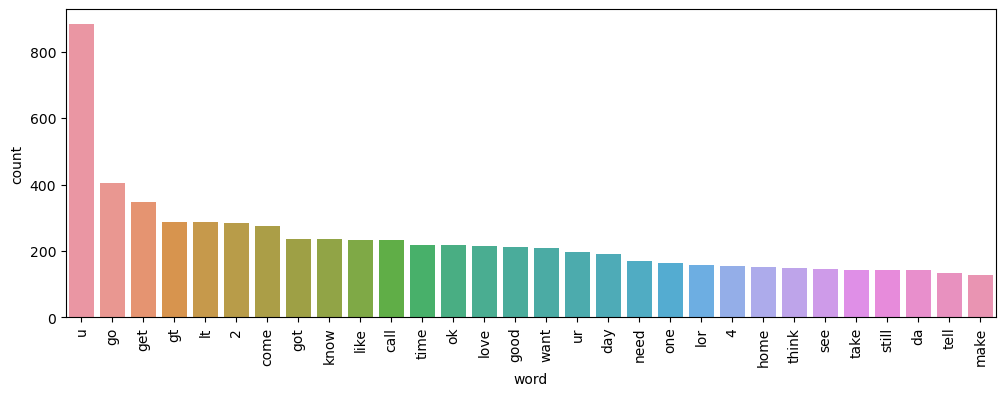

In [47]:
plt.figure(figsize=(12,4))
sns.barplot(data=df_ham_count, x = 'word', y='count')
plt.xticks(rotation='vertical')
plt.show()

## **5. ML Model**

### **5.1. Split the Data to X and y**

In [48]:
df.head(3)

,Text,Target,num_characters,num_words,num_sentences,Transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...


In [49]:
# Text to tokens 
#cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [50]:
X = tfidf.fit_transform(df['Transformed_text']).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
X.shape

(5169, 6708)

In [52]:
y = df['Target'].values
y[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1])

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=3)

In [54]:
X_train.shape,  X_test.shape,  y_train.shape,  y_test.shape

((4135, 6708), (1034, 6708), (4135,), (1034,))

### **5.2. Naive Bayes Classifiers**

In [55]:
gnb = GaussianNB()     # Gaussian Naive Bayes
mnb = MultinomialNB()  # Multinomial Naive Bayes
bnb = BernoulliNB()    # Bernoulli Naive Bayes

In [56]:
# Gaussian Naive Bayes
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)

print('Gaussian Naive Bayes Accuracy:', round(accuracy_score(y_test,y_pred1),2))
print('Gaussian Naive Bayes Precision:', round(precision_score(y_test,y_pred1),2))
print('Gaussian Naive Bayes Confusion matrix: \n', confusion_matrix(y_test,y_pred1))

Gaussian Naive Bayes Accuracy: 0.86
Gaussian Naive Bayes Precision: 0.5
Gaussian Naive Bayes Confusion matrix: 
 [[773 121]
 [ 19 121]]


In [57]:
 # Bernoulli Naive Bayes
bnb.fit(X_train,y_train)
y_pred2 = bnb.predict(X_test)

print('Bernoulli Naive Bayes Accuracy:', round(accuracy_score(y_test,y_pred2),2))
print('Bernoulli Naive Bayes Precision:', round(precision_score(y_test,y_pred2),2))
print('Bernoulli Naive Bayes Confusion matrix: \n', confusion_matrix(y_test,y_pred2))

Bernoulli Naive Bayes Accuracy: 0.97
Bernoulli Naive Bayes Precision: 0.98
Bernoulli Naive Bayes Confusion matrix: 
 [[892   2]
 [ 30 110]]


In [58]:
# Multinomial Naive Bayes
mnb.fit(X_train,y_train)
y_pred3 = mnb.predict(X_test)

print('Multinomial Naive Bayes Accuracy:', round(accuracy_score(y_test,y_pred3),2))
print('Multinomial Naive Bayes Precision:', round(precision_score(y_test,y_pred3),2))
print('Multinomial Naive Bayes Confusion matrix: \n', confusion_matrix(y_test,y_pred3))

Multinomial Naive Bayes Accuracy: 0.96
Multinomial Naive Bayes Precision: 1.0
Multinomial Naive Bayes Confusion matrix: 
 [[894   0]
 [ 46  94]]


In [59]:
n_labels=df['Target'].nunique()
#print(n_labels)
confusion_mat = confusion_matrix(y_test,y_pred3)
pd.DataFrame(confusion_mat,columns=list(range(0,n_labels)))

,0,1
0,894,0
1,46,94


Text(0.5, 3.722222222222216, 'Predicted Labels')

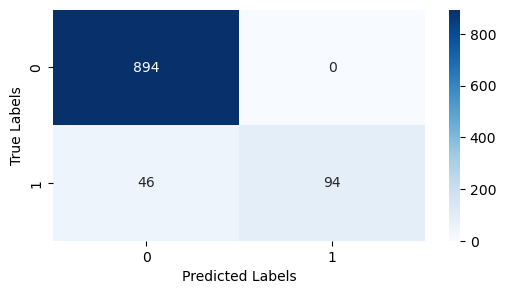

In [60]:
plt.figure(figsize=(6,3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

## **6. Save the Trained model**

In [61]:
# Save the trained ML model 
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))   # tfidf - vectorizer : to process the user input text
pickle.dump(mnb,open('model.pkl','wb'))          # Multinomial Naive Bayes

# **END**